In [2]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import torch_input_edges, torch_input_edges, get_X_y
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]

In [3]:
train_ids = mesh_ids[:-20]
test_ids = mesh_ids[-20:]

def sample_rand(train_ids):
    mesh_id = train_ids[np.random.randint(len(train_ids))]
    time_step = np.random.randint(0,79)
    X_nodes, X_edges_undir, y = get_X_y(mesh_id=mesh_id, time_step=time_step)
    return (X_nodes, X_edges_undir, y), mesh_id, time_step

sample_data, sample_mesh_id, sample_ts  = sample_rand(train_ids)
print(sample_mesh_id, sample_ts)
X_nodes, X_edges_undir, y = sample_data

138 9


In [4]:
mesh_id = mesh_ids[0]
X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
print(X_nodes.shape)
print(X_edges.shape)
print(y.shape)

torch.Size([11446, 8])
torch.Size([2, 71718])
torch.Size([11446, 4])


In [5]:
X_nodes

tensor([[-2.2054e+00,  4.5609e+00,  1.6721e+00,  ..., -7.7049e-14,
          1.6914e+02,  0.0000e+00],
        [-2.2580e+00,  4.7989e+00,  1.8013e+00,  ..., -2.8234e-14,
          1.7015e+02,  0.0000e+00],
        [-2.2128e+00,  5.0789e+00,  1.8894e+00,  ...,  2.4044e-14,
          1.7121e+02,  0.0000e+00],
        ...,
        [-3.6852e-01,  9.2672e+00, -7.8628e-01,  ...,  1.1075e+01,
          2.0308e+02,  0.0000e+00],
        [ 1.5326e+00,  6.6809e+00,  6.5583e-01,  ..., -1.4455e+01,
          1.7184e+02,  0.0000e+00],
        [ 6.5601e+00,  2.1587e+00, -6.2134e-01,  ...,  6.3883e-01,
          1.3828e+02,  0.0000e+00]])

In [170]:
mesh_id = mesh_ids[0]
X_nodes_1, X_edges_1, y_1 = get_X_y(mesh_id, time_step=1)

def get_walls(X_nodes):
    velocities = torch.norm(X_nodes[:,3:6], p=2, dim=1)
    border = torch.where(velocities < 1e-10)[0]
    return border

border = get_walls(X_nodes)

In [6]:
import matplotlib.pyplot as plt

diff = X_nodes_1[:,3:] - X_nodes[:, 3:]
border_mask = np.zeros(X_nodes.shape[0])
border_mask[border] = 1

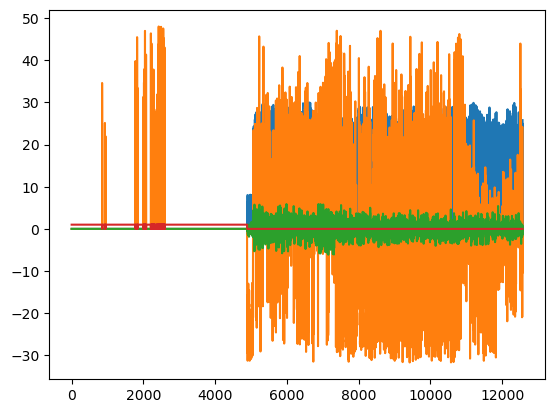

In [7]:
plt.plot(diff[:,:3])
plt.plot(border_mask);

/var/folders/m7/fyj040hx1x1fw7ttkzlnffgr0000gn/T/ipykernel_82582/2107745973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  truc = torch.load("data_cleaned/mesh_1.pth")


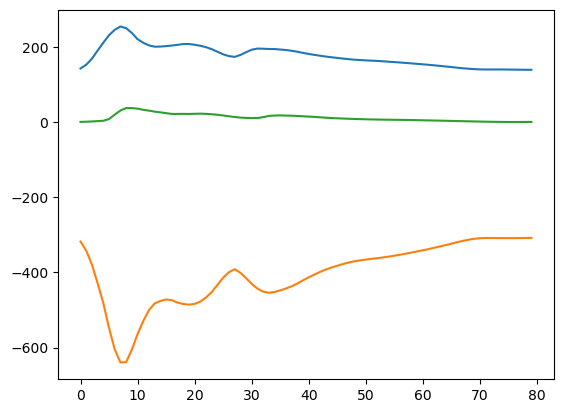

In [8]:
truc = torch.load("data_cleaned/mesh_1.pth")
a = truc["nodes"]
for i in range(3,6):
    plt.plot(a[:,-1,i])

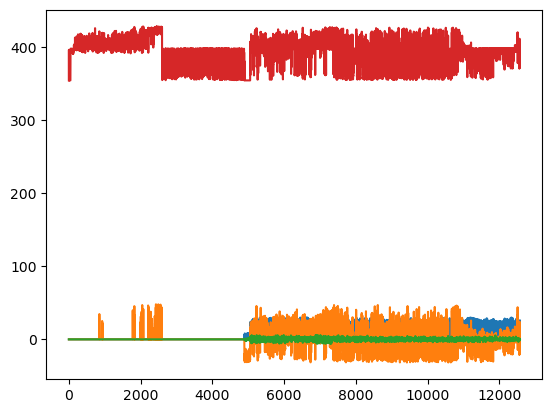

In [9]:
plt.plot(diff)

## model explo

In [10]:
X_edges_dir = torch.cat([X_edges, X_edges[[1, 0], :]], dim=1)

In [ ]:
def create_edge_attributes(X_nodes, X_edges_undir):
    """
    Create edge attributes for a graph based on node positions and undirected edges.

    Parameters:
    X_nodes (torch.Tensor): A tensor of shape (num_nodes, num_features) containing the node features,
                            where the first three columns represent the 3D positions of the nodes.
    X_edges_undir (torch.Tensor): A tensor of shape (2, num_edges) containing the undirected edges,
                                  where each column represents an edge with the indices of the two nodes it connects.

    Returns:
    torch.Tensor: A tensor of shape (num_edges * 2, 4) containing the edge attributes,
                  where each row represents an edge with the direction vector (3D) and the distance (1D).
    """
    positions = X_nodes[:,0:3]
    X_edges_dir = torch.cat([X_edges, X_edges[[1, 0], :]], dim=1)
    i, j = X_edges_dir
    direction = positions[j,:] - positions[i,:]
    distance = torch.norm(direction, dim=1, keepdim=True)
    direction /= distance
    edge_attr = torch.cat([direction, distance], dim=1)
    return edge_attr

In [12]:
from torch_geometric.data import Data

edge_attr = create_edge_attributes(X_nodes, X_edges_undir)
data = Data(x=X_nodes, edge_index=X_edges_dir, edge_attr=edge_attr)

In [13]:
from torch_geometric.nn import GraphUNet
import torch.nn.functional as F


in_channels = X_nodes.shape[1]
hidden_channels = 32
out_channels = 16
model = GraphUNet(in_channels, hidden_channels, out_channels, depth=3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

In [14]:
model(data.x, data.edge_index)

/opt/miniconda3/envs/env_challenge/lib/python3.12/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(


RuntimeError: addmm: computation on CPU is not implemented for SparseCsr + SparseCsr @ SparseCsr without MKL. PyTorch built with MKL has better support for addmm with sparse CPU tensors.

In [ ]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    sample_data, sample_mesh_id, sample_ts  = sample_rand(train_ids)
    X_nodes, X_edges_undir, y = sample_data
    X_edges_dir = torch.cat([X_edges, X_edges[[1, 0], :]], dim=1)
    edge_attr = create_edge_attributes(X_nodes[:,0:3], X_edges_dir)
    data = Data(x=X_nodes, edge_index=X_edges_dir, edge_attr=edge_attr)
    
    output = model(data.x, data.edge_index)
    
    # Compute the loss (example using MSE loss)
    loss = F.mse_loss(output, data.x)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: Calling addmm on CPU with sparse output requires MKL.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(node_features, edge_index, edge_attr)

    loss = F.mse_loss(out, y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 37934.09765625
Epoch 1, Loss: 36062.69140625
Epoch 2, Loss: 34006.6171875
Epoch 3, Loss: 31688.48828125
Epoch 4, Loss: 29154.5546875
Epoch 5, Loss: 26384.498046875
Epoch 6, Loss: 23449.873046875
Epoch 7, Loss: 20414.73046875
Epoch 8, Loss: 17461.56640625
Epoch 9, Loss: 14870.36328125
Epoch 10, Loss: 12950.4052734375
Epoch 11, Loss: 12061.2646484375
Epoch 12, Loss: 12065.03125
Epoch 13, Loss: 12292.5458984375
Epoch 14, Loss: 12069.6083984375
Epoch 15, Loss: 11181.521484375
Epoch 16, Loss: 9823.025390625
Epoch 17, Loss: 8336.51953125
Epoch 18, Loss: 7009.80029296875
Epoch 19, Loss: 5989.47412109375
Epoch 20, Loss: 5290.40869140625
Epoch 21, Loss: 4836.7763671875
Epoch 22, Loss: 4516.962890625
Epoch 23, Loss: 4234.220703125
Epoch 24, Loss: 3936.4619140625
Epoch 25, Loss: 3615.389892578125
Epoch 26, Loss: 3290.161865234375
Epoch 27, Loss: 2998.230712890625
Epoch 28, Loss: 2784.5595703125
Epoch 29, Loss: 2682.091552734375
Epoch 30, Loss: 2686.587890625
Epoch 31, Loss: 2747.98

In [ ]:
mesh_id = mesh_ids[58]
X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
node_features = X_nodes
edge_index = X_edges
edge_attr = create_edge_attributes(node_features[:,0:3], edge_index)

In [ ]:
out = model(node_features, edge_index, edge_attr)
loss = F.mse_loss(out, y)
print(loss.item())

969.9053955078125
